In [1]:
%matplotlib inline
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable


- blur of 4 is iffy for which eye dominates -- trying with blur of 6
- from "2023-02-07 Deficit Sims -- Blur - Jitter sigma - Longer Runs to Check Convergence" I get that a $\mu_c=7.5$ gives a robust deficit with blur=6 and $\sigma_c$ doesn't much matter, so I'll take a $\sigma_c=2$ to give some variability. 

In [2]:
from deficit_defs import *

Splikes version  0.1.2
Plasticnet version  0.1.9
macOS-10.16-x86_64-i386-64bit


In [3]:
def savefig(base):
    import matplotlib.pyplot as plt
    for fname in [f'Manuscript/resources/{base}.png',f'Manuscript/resources/{base}.svg']:
        print(fname)
        plt.savefig(fname, bbox_inches='tight')

In [4]:
_debug = False
if _debug:
    print("Debugging")

In [5]:
base='sims/2023-02-19'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

In [6]:
rf_size=19
eta=2e-6
blur=6
mu_c_mat=[0,7.5]
sigma_c_mat=[0,2]

open_eye_noise_mat=linspace(0,1,21)
display(open_eye_noise_mat)


number_of_neurons=20
number_of_processes=4

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [7]:
def blur_jitter_deficit(blur=[2.5,-1],
                        noise=[0.1,.1],
                        rf_size=19,eta=2e-6,
                        mu_c=0,sigma_c=1,    
                        mu_r=0,sigma_r=1,
                        number_of_neurons=10,
                        total_time=8*day,
                        save_interval=1*hour):

    
    if _debug:
        total_time=1*minute
        save_interval=1*second
        
    images=[]
    dt=200*ms
    
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'dog','sd1':1,'sd2':3},
                                {'type':'norm'},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'dog','sd1':1,'sd2':3},
                                    {'type':'norm'},
                                    )
        images.append(im)
        
        
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=1,
                                                sigma_c=1,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)



    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]

In [8]:
def fix_jitter(noise=0.1,rf_size=19,
           number_of_neurons=10,
            mu_c=0,sigma_c=0,    
            mu_r=0,sigma_r=0,
           total_time=8*day,
           save_interval=1*hour,
           eta=2e-6):
    
    if _debug:
        total_time=1*minute
        save_interval=1*second

    im=pi5.filtered_images(
                        base_image_file,
                        {'type':'dog','sd1':1,'sd2':3},
                        {'type':'norm'},
                        )
    
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(im,
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                verbose=False)
    pre2=pn.neurons.natural_images_with_jitter(im,
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)


    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]



In [9]:
def run_one(params,overwrite=False):
    import plasticnet as pn
    
    count,eta,noise,blur,number_of_neurons,sfname,mu_c,sigma_c=(params.count,params.eta,params.noise,params.blur,
                                        params.number_of_neurons,params.sfname,params.mu_c,params.sigma_c)
    
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()

    t=16*day
    ts=1*hour

    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=blur_jitter_deficit(blur=[blur,-1],
                                total_time=t,
                                noise=noise,eta=eta,number_of_neurons=number_of_neurons,
                                mu_c=mu_c,sigma_c=sigma_c,
                                save_interval=ts)

    t=16*hour*7*2  # two weeks
    ts=1*hour
    
    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=fix_jitter(total_time=t,
           save_interval=ts,
                                mu_c=mu_c,sigma_c=sigma_c,
             eta=eta,noise=noise,number_of_neurons=number_of_neurons)

    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname
    
    
    

In [10]:
from collections import namedtuple
params = namedtuple('params', ['count', 'eta','noise','blur','number_of_neurons','sfname','mu_c','sigma_c'])
all_params=[]
count=0
eta_count=0
noise_count=0
open_eye_noise=0.0

for mu_count,mu_c in enumerate(mu_c_mat):
    for sigma_count,sigma_c in enumerate(sigma_c_mat):
        for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
            all_params.append(params(count=count,
                             eta=eta,
                                 blur=blur,
                             noise=open_eye_noise,
                             number_of_neurons=number_of_neurons,
                                     
             sfname=f'{base}/continuous fix {number_of_neurons} neurons {noise_count} noise {mu_c} mu_c {sigma_c} sigma_c.asdf',
                                    mu_c=mu_c,sigma_c=sigma_c))

            count+=1
        
for a in all_params[:5]:
    print(a)
print("[....]")
for a in all_params[-5:]:
    print(a)



params(count=0, eta=2e-06, noise=0.0, blur=6, number_of_neurons=20, sfname='sims/2023-02-19/continuous fix 20 neurons 0 noise 0 mu_c 0 sigma_c.asdf', mu_c=0, sigma_c=0)
params(count=1, eta=2e-06, noise=0.05, blur=6, number_of_neurons=20, sfname='sims/2023-02-19/continuous fix 20 neurons 1 noise 0 mu_c 0 sigma_c.asdf', mu_c=0, sigma_c=0)
params(count=2, eta=2e-06, noise=0.1, blur=6, number_of_neurons=20, sfname='sims/2023-02-19/continuous fix 20 neurons 2 noise 0 mu_c 0 sigma_c.asdf', mu_c=0, sigma_c=0)
params(count=3, eta=2e-06, noise=0.15000000000000002, blur=6, number_of_neurons=20, sfname='sims/2023-02-19/continuous fix 20 neurons 3 noise 0 mu_c 0 sigma_c.asdf', mu_c=0, sigma_c=0)
params(count=4, eta=2e-06, noise=0.2, blur=6, number_of_neurons=20, sfname='sims/2023-02-19/continuous fix 20 neurons 4 noise 0 mu_c 0 sigma_c.asdf', mu_c=0, sigma_c=0)
[....]
params(count=79, eta=2e-06, noise=0.8, blur=6, number_of_neurons=20, sfname='sims/2023-02-19/continuous fix 20 neurons 16 noise 7.5

In [12]:
real_time=11*60+ 30

In [13]:
do_params=make_do_params(all_params)
print(len(do_params))
print(time2str(real_time*len(do_params)/number_of_processes))

0
0.00 s


In [23]:
%%time
if do_params:
    run_one(do_params[0],overwrite=True)

Using cache_images/cache_images_5fea507ccefa3e7dae672bfff0af4b53.asdf from cache.Using cache_images/cache_images_395ed573cbab94baa435fdeb1e2b01d2.asdf from cache.Using cache_images/cache_images_395ed573cbab94baa435fdeb1e2b01d2.asdf from cache.[..] Sequence Time Elapsed...7 m, 44.36 s
CPU times: user 33min 52s, sys: 13min 24s, total: 47min 16s
Wall time: 7min 49s


In [13]:
if do_params:
    pool = Pool(processes=number_of_processes)
    result = pool.map_async(run_one, do_params)
    print(result.get())

In [14]:
RR={}
for params in tqdm(all_params):
    RR[params.sfname]=Results(params.sfname)

  0%|          | 0/84 [00:00<?, ?it/s]

In [15]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


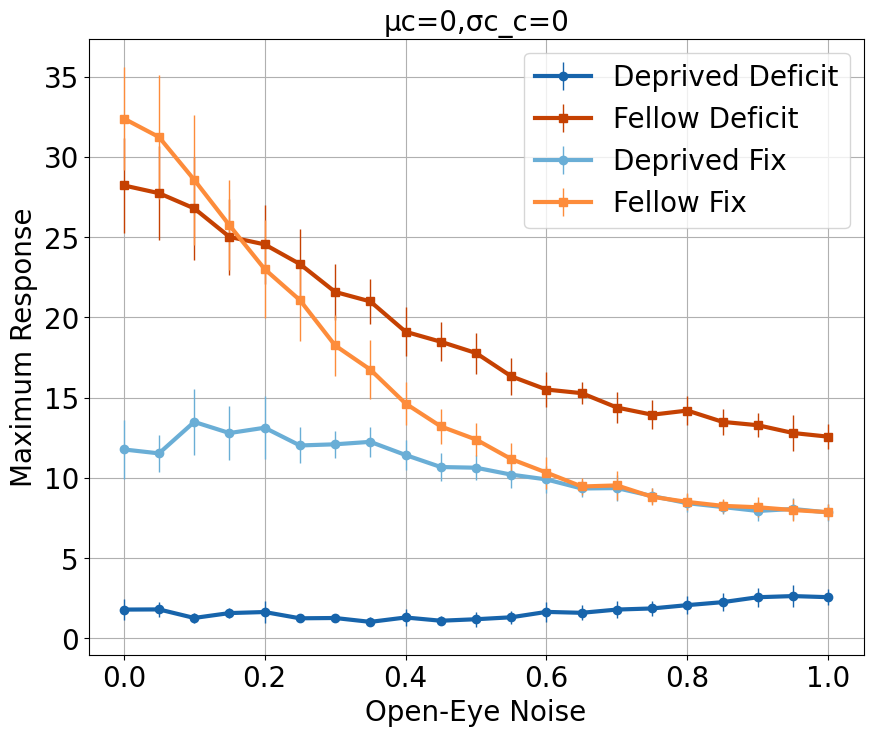

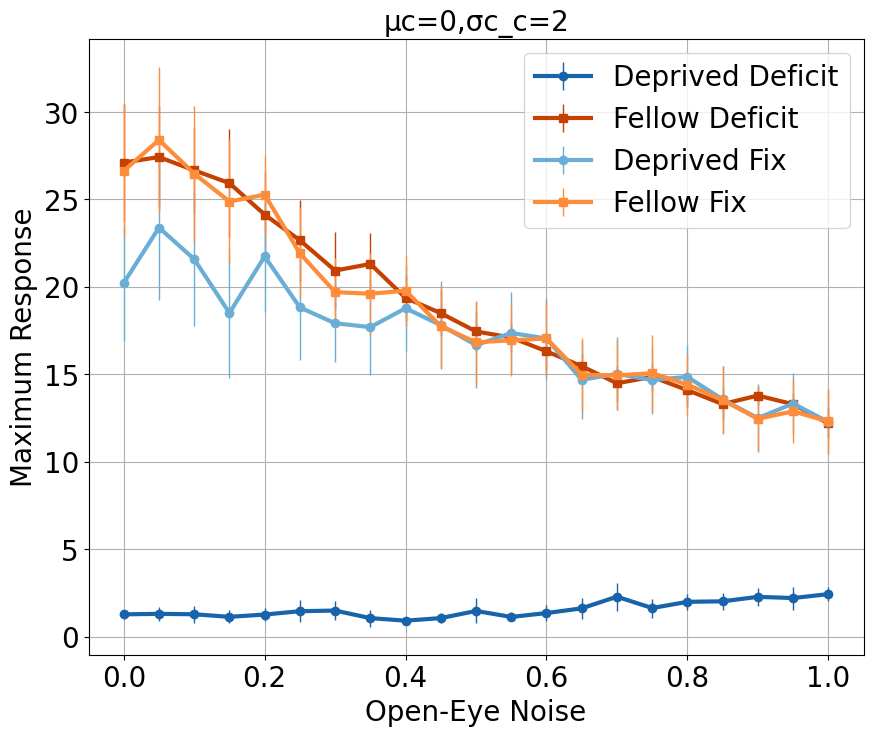

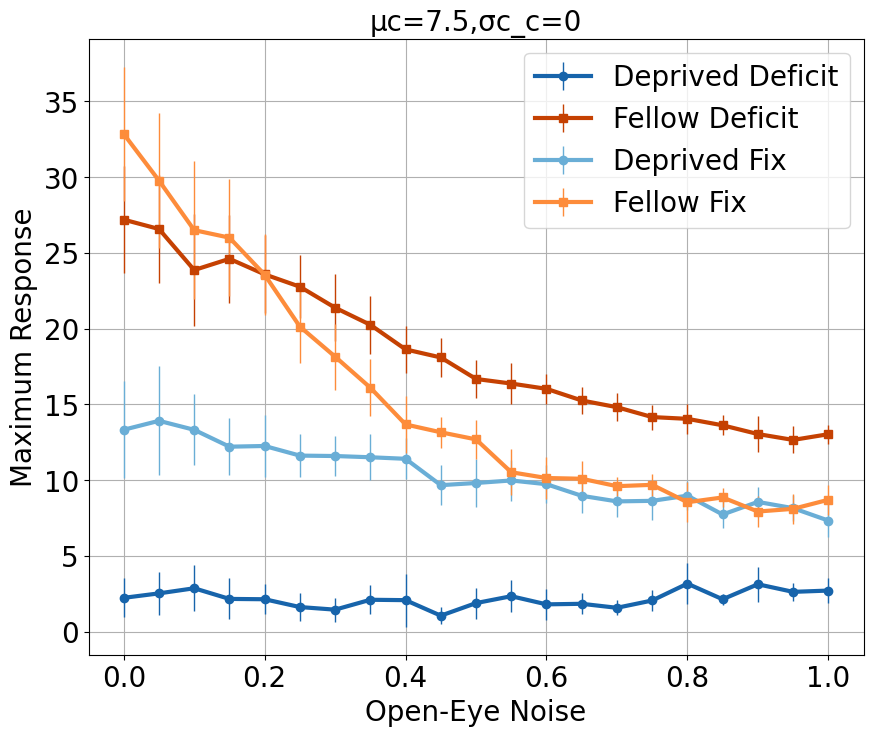

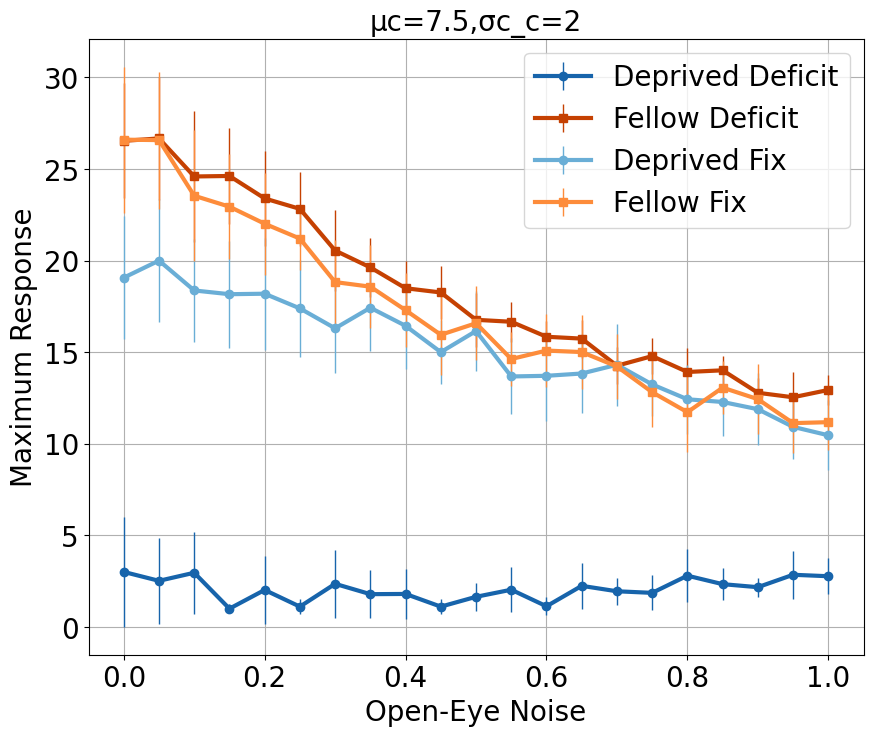

In [22]:
Blues2 = truncate_colormap(cm.Blues, 0.3, 1.0).reversed()
Oranges2 = truncate_colormap(cm.Oranges, 0.3, 1.0).reversed()


count=0
for mu_count,mu_c in enumerate(mu_c_mat):
    for sigma_count,sigma_c in enumerate(sigma_c_mat):
        s=Storage()
        count_save=count
        for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
            params=all_params[count]
            count+=1

            R=RR[params.sfname]
            noise=params.noise
            μ1,μ2=R.μσ[0][0]
            σ1,σ2=R.μσ[1][0]

            s+=noise,μ1,μ2,σ1,σ2


        noise,μ1,μ2,σ1,σ2=s.arrays()

        figure()
        errorbar(noise,μ1,yerr=2*σ1,marker='o',elinewidth=1,label='Deprived Deficit',
                color=cm.Blues(.8))
        errorbar(noise,μ2,yerr=2*σ2,marker='s',elinewidth=1,label='Fellow Deficit',
                color=cm.Oranges(.8))
        xlabel('Open-Eye Noise')
        ylabel('Maximum Response')
        title(f'μc={mu_c},σc_c={sigma_c}')
        
        
        # afterward
        s=Storage()
        count=count_save
        
        for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
            params=all_params[count]
            count+=1

            R=RR[params.sfname]
            noise=params.noise
            μ1,μ2=R.μσ[0][1]
            σ1,σ2=R.μσ[1][1]

            s+=noise,μ1,μ2,σ1,σ2


        noise,μ1,μ2,σ1,σ2=s.arrays()
        errorbar(noise,μ1,yerr=2*σ1,marker='o',elinewidth=1,label='Deprived Fix',
                color=cm.Blues(.5))
        errorbar(noise,μ2,yerr=2*σ2,marker='s',elinewidth=1,label='Fellow Fix',
                color=cm.Oranges(.5))
        
        legend()            
        

what's weird here is that there seems to be no recovery.

In [72]:
sfname='sims/2023-02-19/continuous fix 20 neurons 10 noise 7.5 mu_c 2 sigma_c.asdf'
#R=Results(sfname)
R=RR[sfname]

In [73]:
weak_i=0
strong_i=1

sims/2023-02-19/continuous fix 20 neurons 10 noise 7.5 mu_c 2 sigma_c.asdf


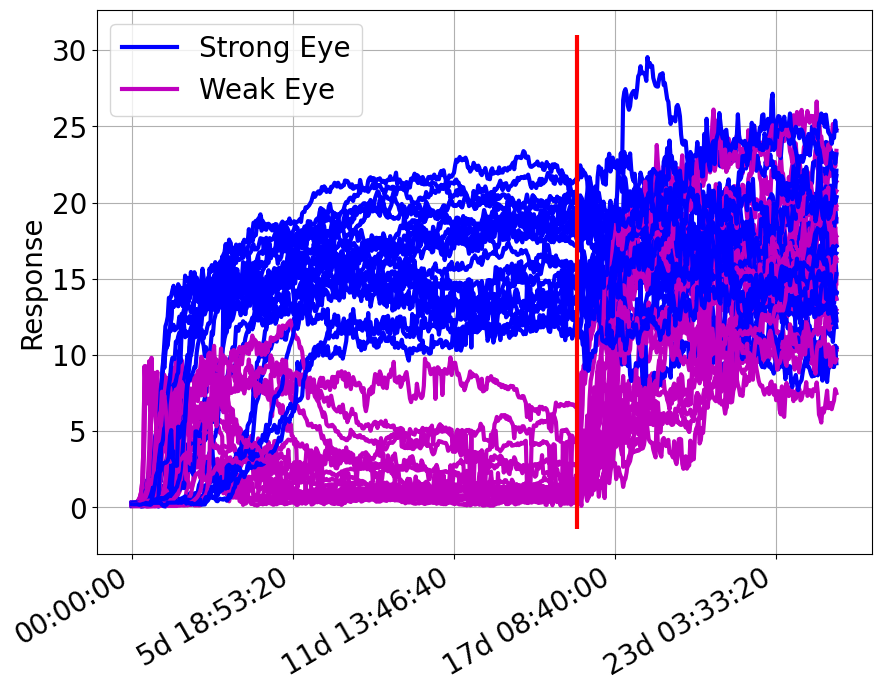

In [74]:
plot(R.t,R.y[:,0,strong_i],'b',label='Strong Eye')
plot(R.t,R.y[:,0,weak_i],'m',label='Weak Eye')

for n in range(20):
    plot(R.t,R.y[:,n,0],'m')
    plot(R.t,R.y[:,n,1],'b')
    
yl=gca().get_ylim()
vlines(R.sequence_times[1][0],yl[0],yl[1],'r')
    
ylabel('Response')
legend()
print(sfname)
reformat_time_axis()    

so there is recovery it's just a lot more variable.

What I need to do is:

1. run a single set of 20 neuron deficit sims to reduce the variation
2. make sure that the set of deficit sims have reasonable response vs time profiles before continuing
3. then run all the treatment from that single set

In [75]:
R.μσ

([array([ 1.65411993, 16.76898133]), array([16.15606593, 16.5816031 ])],
 [array([0.38399007, 0.73933251]), array([1.08944008, 1.00795766])])

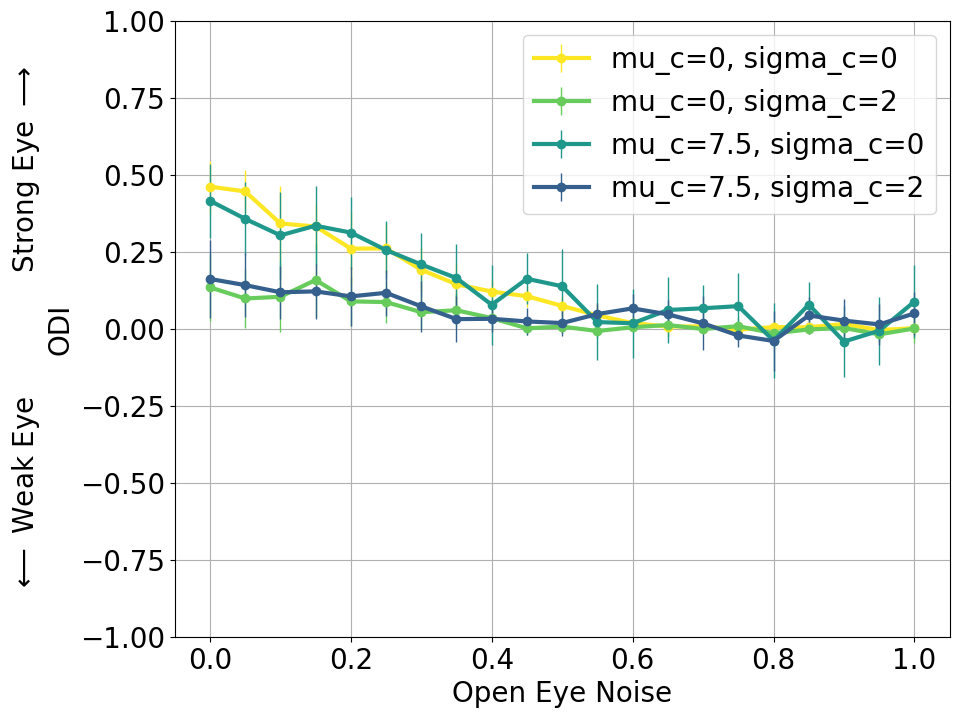

In [21]:
count=0
v_count=0
v=np.flip(linspace(0.3,1,len(mu_c_mat)*len(sigma_c_mat)))
for mu_count,mu_c in enumerate(mu_c_mat):
    for sigma_count,sigma_c in enumerate(sigma_c_mat):
        s=Storage()
        for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
            params=all_params[count]
            count+=1

            R=RR[params.sfname]

            noise=params.noise
            μ,σ=μσ(R.ODI[-1])

            s+=noise,μ,σ
    
    
        noise,μ,σ=s.arrays()
        errorbar(noise,μ,yerr=2*σ,marker='o',elinewidth=1,color=cm.viridis(v[v_count]),
                label=f'mu_c={mu_c}, sigma_c={sigma_c}')    
        
        v_count+=1
        
xlabel('Open Eye Noise')
ylabel(r'$\longleftarrow$ Fellow Eye              Amblyopic Eye $\longrightarrow$'+"\nODI")
ylim([-1,1])

legend()

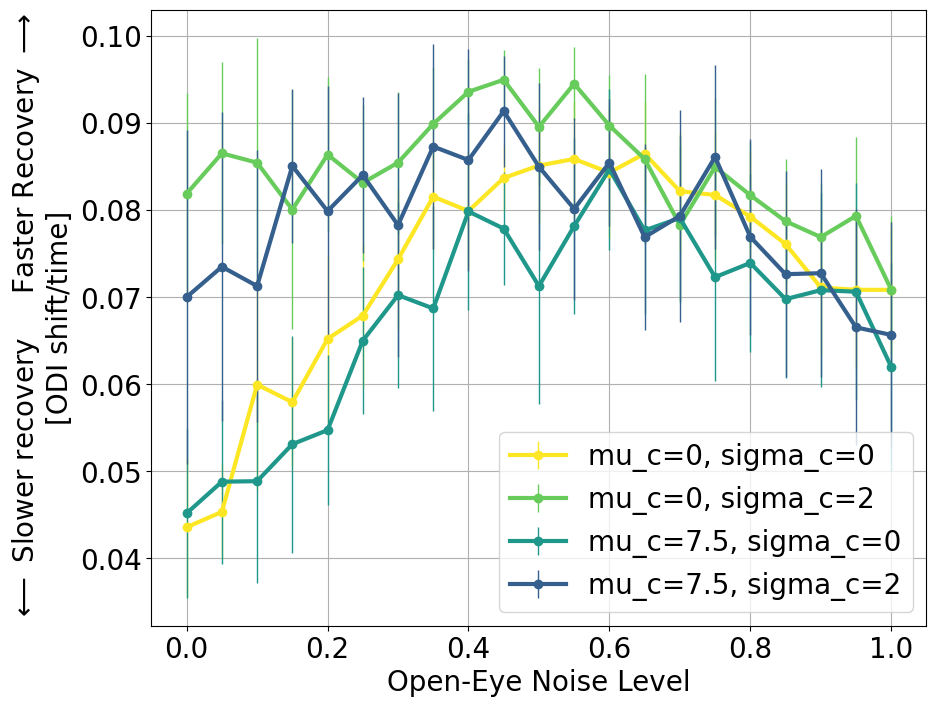

In [25]:
count=0
v_count=0
v=np.flip(linspace(0.3,1,len(mu_c_mat)*len(sigma_c_mat)))
for mu_count,mu_c in enumerate(mu_c_mat):
    for sigma_count,sigma_c in enumerate(sigma_c_mat):
        s=Storage()
        for noise_count,open_eye_noise in enumerate(open_eye_noise_mat):
            params=all_params[count]
            count+=1

            R=RR[params.sfname]

            noise=params.noise
            idx1,idx2=[_[1] for _ in R.sequence_index]
            t=R.t/day
            recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
            
            s+=noise,recovery_rate_μ,recovery_rate_σ
    
    
        noise,recovery_rate_μ,recovery_rate_σ=s.arrays()    
        
        
        errorbar(noise,-recovery_rate_μ,yerr=2*recovery_rate_σ,
                 marker='o',elinewidth=1,color=cm.viridis(v[v_count]),
                label=f'mu_c={mu_c}, sigma_c={sigma_c}')    
        
        v_count+=1
        
ylabel(r'$\longleftarrow$ Slower recovery     Faster Recovery $\longrightarrow$'+"\n[ODI shift/time]")
xlabel('Open-Eye Noise Level')

legend()

In [ ]:
import cycler
n = 5
color = cm.viridis(np.linspace(0, 1,n))

noise,recovery_rate_μ,recovery_rate_σ=glasses_result

errorbar(noise,-recovery_rate_μ,yerr=2*recovery_rate_σ,elinewidth=1,
        color=color[0]) # positive = recovery
ylabel(r'$\longleftarrow$ Slower recovery     Faster Recovery $\longrightarrow$'+"\n[ODI shift/time]")
xlabel('Open-Eye Noise Level')
#title('Glasses Fix')

